# Import Libraries

In [1]:
import braket
from braket.circuits import Circuit
from braket.devices import LocalSimulator

import numpy as np
import matplotlib.pyplot as plt

plt.style.use("dark_background")

# Needed functions

As we have gone through, we need the inverse QFT for this algorithm!

In [2]:
def build_aws_qft_circuit(qubits_count):
    
    qubits = list(range(qubits_count))
    
    circuit = Circuit()
    
    # Add Hadamards and Controlled RZs
    
    for target_qubit in qubits:
        for control_qubit in range(target_qubit, qubits_count):
            if control_qubit == target_qubit:
                circuit.h(control_qubit)
            else:
                theta = np.pi / 2 ** (control_qubit - target_qubit)
                circuit.cphaseshift(control_qubit, target_qubit, theta)
                
    # Add SWAPs
    
    for qubit_index in range(qubits_count // 2):
        reversed_qubit_index = -qubit_index - 1
        circuit.swap(qubits[qubit_index], 
                     qubits[reversed_qubit_index])
                
    return circuit

# The Problem For QPE

Given a unitary matrix $U$ and a quantum state $|u\rangle$, where the quantum state is a eigenstate of the unitary matrix $U$ such that :

$$ U |u\rangle = e^{2π𝑖𝜑}|u\rangle $$

We want to find $𝜑$.

# Simple Example:

Let us consider the simple phase shift gate:

According to the documentation, the phase shift gate implements:

phaseshift(phi)= diag([1,exp(1j*$\phi$)]) 

Which means when you implement the phase shift on $|1\rangle$, we get $P|1\rangle = e^{i\phi}|1\rangle$.

In [3]:
# We want to have it in the above form
INITIAL_PHI = 1 / 8

angle = 2 * np.pi * INITIAL_PHI

In [4]:
circ = Circuit()
circ.x(0)
circ.phaseshift(0,angle)
circ.state_vector()

Circuit('instructions': [Instruction('operator': X('qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1), Instruction('operator': PhaseShift('angle': 0.7853981633974483, 'qubit_count': 1), 'target': QubitSet([Qubit(0)]), 'control': QubitSet([]), 'control_state': (), 'power': 1)], 'result_types': [StateVector()])

In [5]:
print(circ)

T  : |0|     1     |
                    
q0 : -X-PHASE(0.79)-

T  : |0|     1     |

Additional result types: StateVector


In [6]:
device = LocalSimulator()

task = device.run(circ)
result = task.result()

In [7]:
result.values

[array([0.        +0.j        , 0.70710678+0.70710678j])]

Now, we don't just need to be able to implement the unitary, we also need to be able to implement the controlled version of it, of which there is the function in AWS:

In [8]:
# circ.cphaseshift(0, 1, angle)

Know that this is possible, and also an active area of research (to reduce complexity). For one of the more fun papers to read about it:
    
https://www.nature.com/articles/ncomms1392

# Implementation of QPE for the Simple Example

## The Problem For QPE for the Simple Example

Given a phase-shift operator $P$ as defined above where we don't know what the angle of the phase shift is but know how to apply it, we want to find the value of the angle. 

We know that $|1\rangle$ is an eigenstate of the phase-shift operator.

## The code for QPE for the Simple Example

In [9]:
def build_aws_qpe_circuit(angle, precision):
    
    ## Qubit Counts
    
    # Since we are implementing the phase shift
    UNITARY_QUBITS_COUNT = 1
    
    # We want to know how precise to go. 
    counting_qubits_count = precision
    
    total_qubits_count = counting_qubits_count + UNITARY_QUBITS_COUNT
    counting_qubits = list(range(counting_qubits_count))
    unitary_qubits = list(range(counting_qubits_count,
                                total_qubits_count))
    
    # Circuit
    
    qpe_circuit = braket.circuits.Circuit()
    
    # Superposition
    
    qpe_circuit.h(counting_qubits)
    
    # Eigenstate
    
    qpe_circuit.x(unitary_qubits)
    
    # Apply Controlled Phase Shifts
    
    repetitions = 1
    
    for counting_qubit in reversed(counting_qubits):
        
        for repetition in range(repetitions):
            qpe_circuit.cphaseshift(angle=angle, 
                                    control=counting_qubit, 
                                    target=unitary_qubits)        
        repetitions *= 2
        
    # Inverse QFT
    
    qft_circuit = build_aws_qft_circuit(counting_qubits_count)
    inverted_qft_circuit = qft_circuit.adjoint()
    qpe_circuit.add_circuit(inverted_qft_circuit,
                            target=counting_qubits)
    
    return qpe_circuit

# Running the function

Get an angle we want to find, and determine how precise we want to be

In [10]:
# Get an angle (this is information we don't know)
INITIAL_PHI = 1 / 8
angle = 2 * np.pi * INITIAL_PHI

# In this case we think 2^(-3) will be precise enough
PRECISION = 3
counting_qubits = list(range(PRECISION))

SHOTS = 2048

Now we build the QPE circuit for phaseshift

In [11]:
qpe_circuit = build_aws_qpe_circuit(angle, precision=PRECISION)

qpe_circuit.probability(target=counting_qubits)

print(qpe_circuit)

T  : |0|     1     |     2     |     3     |     4     |     5     |     6     |     7     | 8  |9|  10   |   11    |  12   |13|Result Types|
                                                                                                                                             
q0 : -H-------------------------------------C-----------C-----------C-----------C-----------SWAP-------------(-0.79)-(-1.57)-H--Probability--
                                            |           |           |           |           |                |       |          |            
q1 : -H-------------C-----------C-----------|-----------|-----------|-----------|-----------|------(-1.57)-H-|-------(-1.57)----Probability--
                    |           |           |           |           |           |           |      |         |                  |            
q2 : -H-C-----------|-----------|-----------|-----------|-----------|-----------|-----------SWAP-H-(-1.57)---(-0.79)------------Probability--
      

And now we run it

In [12]:
device = LocalSimulator()

task = device.run(qpe_circuit, shots=SHOTS)
result = task.result()

probabilities = result.values[0]

probabilities

array([0., 1., 0., 0., 0., 0., 0., 0.])

In [13]:
result.measurement_probabilities

{'0011': 1.0}

In [14]:
 # States

QUBITS_COUNT = PRECISION

state_format = f"0{QUBITS_COUNT}b"

states = list(range(2 ** QUBITS_COUNT))
states_strings = [f"{state:{state_format}}" for state in states]

states_strings

['000', '001', '010', '011', '100', '101', '110', '111']

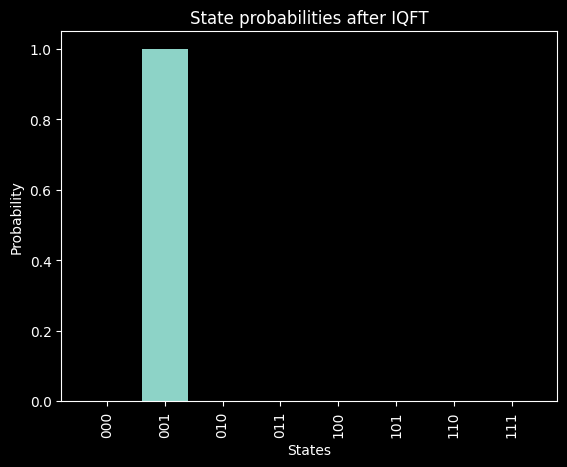

In [15]:
# Plot Probabilities

plt.bar(states_strings, probabilities)

plt.title("State probabilities after IQFT")
plt.xlabel("States")
plt.ylabel("Probability")

plt.xticks(rotation=90);

In [19]:
idx_max = np.argmax(probabilities)
print(states_strings[idx_max])

'001'

In [24]:
total = 0
for i,b in enumerate(states_strings[idx_max]):
    total = total + int(b) * 2**(-(i+1))

In [23]:
print(total)

0.125

In [25]:
angle_predicted = 2 * np.pi * total
print(angle_predicted)

0.7853981633974483


In [26]:
print(angle)

0.7853981633974483
